# Sokoban

Import libraries, including Sokoban.py which has the class with the dynamics of the environment

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np
import time
from Sokoban import Sokoban

## Environment

### Useful Functions

In [2]:
def try_game(env, policy):

    s, _ = env.reset()

    for i in range(50):
        action = policy[s]
        s, _ , terminated, *_ = env.step(action)
        if terminated:
            print('The game ended at step {}'.format(i + 1))
            break
    env.close()

# Q-learning MDP

In [40]:
def choose_action_MDP(values, epsilon):
    if random.random() < epsilon:
        # exploration
        return random.choice(range(len(values)))
    else:
        # explotation
        v = np.argwhere(values == np.amax(values)).flatten()
        if len(v) > 0:
            return random.choice(v)
        else:
            return random.choice(range(len(values)))

In [41]:
def QMDP_learning(env, num_episodes=1000, num_steps=100, alpha=0.05, gamma=0.99, eps_max = 1, eps_min = 0.05, chunk_size=1000):
    
    timings = []
    timings.append((time.time_ns(), 'start'))

    Q = np.zeros((20, 20, 20, env.Na))

    epsilon = eps_max
    eps_step = (eps_max - eps_min) / num_episodes

    scores = []

    print('               Mean   epsilon')

    for episode in range(num_episodes):
        score = 0

        s, _ = env.reset()
        al, b1, b2 = s

        new_state = True

        timings.append((time.time_ns(), 'episode overhead'))

        for step in range(num_steps):
            
            a = choose_action_MDP(Q[al, b1, b2], epsilon if not new_state else 1)
            timings.append((time.time_ns(), 'action selection'))

            new_state = False
            new_s, reward, terminated, *_ = env.step(a)
            al_, b1_, b2_ = new_s
            timings.append((time.time_ns(), 'step performance'))

            score += reward
            timings.append((time.time_ns(), 'score update'))

            Q[al, b1, b2, a] = Q[al, b1, b2, a] + alpha * (reward + gamma * np.max(Q[al_, b1_, b2_]) - Q[al, b1, b2, a])
            timings.append((time.time_ns(), 'update rule'))
            
            if terminated:
                break
            
            al, b1, b2 = al_, b1_, b2_
            timings.append((time.time_ns(), 'termination checking'))


        scores.append(score)
        timings.append((time.time_ns(), 'score update'))

        epsilon -= eps_step if epsilon > eps_min else 0
        timings.append((time.time_ns(), 'epsilon update'))
        
        if episode % chunk_size == chunk_size-1:

            if episode < chunk_size:
                to_analyze = scores
            else:
                to_analyze = scores[-chunk_size-1:-1]    
            
            print('Chunk {:>3}:  {:>7.2f} | {:.4f}  '.format(episode // chunk_size + 1, np.mean(to_analyze), epsilon))
            timings.append((time.time_ns(), 'print info'))

    return Q, scores, timings

In [42]:
env = Sokoban(level=2)
Q_MDP2, scores_QMDP2, time_QMDP2 = QMDP_learning(env, num_episodes=10000, num_steps=100, alpha=0.1)

               Mean   epsilon
Chunk   1:  -459.20 | 0.9050  
Chunk   2:  -443.34 | 0.8100  
Chunk   3:  -400.30 | 0.7150  
Chunk   4:  -343.31 | 0.6200  
Chunk   5:  -293.66 | 0.5250  
Chunk   6:  -224.26 | 0.4300  
Chunk   7:  -171.38 | 0.3350  
Chunk   8:  -121.32 | 0.2400  
Chunk   9:   -90.57 | 0.1450  
Chunk  10:   -49.13 | 0.0500  


In [43]:
timings_QMDP = {}
for i in range(1, len(time_QMDP2)):
    cat = time_QMDP2[i][1]
    tim = time_QMDP2[i][0] - time_QMDP2[i-1][0]
    if cat not in timings_QMDP:
        timings_QMDP[cat] = tim
    else:
        timings_QMDP[cat] += tim

In [44]:
timings_QMDP

{'episode overhead': 41034100,
 'action selection': 4511823500,
 'step performance': 26675182200,
 'score update': 220385000,
 'update rule': 4032136800,
 'termination checking': 129164200,
 'epsilon update': 12321600,
 'print info': 5084200}

## Q-learning LMDP

In [45]:
def choose_action_LMDP(Q):
    if np.sum(Q) == 0:
        Q = np.ones_like(Q)
    p = Q / np.sum(Q)

    return np.random.choice(len(p), 1, p=p)[0]

In [46]:
def QLMDP_learning(env, num_episodes=10000, num_steps=100, alpha=0.1, eta = 1, chunk_size=1000):
        
    timings = []
    timings.append((time.time_ns(), 'start'))
    
    Q = np.ones((20, 20, 20, env.Na))

    scores = []

    print('           Mean')

    for episode in range(num_episodes):

        score = 0

        s, _ = env.reset()
        al, b1, b2 = s

        timings.append((time.time_ns(), 'episode overhead'))

        for step in range(num_steps):
            
            a = choose_action_LMDP(Q[al, b1, b2])
            timings.append((time.time_ns(), 'action selection'))

            new_s, reward, terminated, *_ = env.step(a)
            al_, b1_, b2_ = new_s
            timings.append((time.time_ns(), 'step performance'))

            score += reward
            timings.append((time.time_ns(), 'score update'))

            Q[al, b1, b2, a] = (1 - alpha) * Q[al, b1, b2, a] + alpha / env.Na * np.exp(eta * reward) * np.sum(Q[al_, b1_, b2_])
            timings.append((time.time_ns(), 'update rule'))

            if terminated:
                break
            
            al, b1, b2 = al_, b1_, b2_
            timings.append((time.time_ns(), 'termination checking'))

            
        scores.append(score)
        timings.append((time.time_ns(), 'score update'))

        if episode % chunk_size == chunk_size-1:

            if episode < chunk_size:
                to_analyze = scores
            else:
                to_analyze = scores[-chunk_size-1:-1]    

            print('Chunk {:>3}: {:>7.2f}'.format(episode // chunk_size + 1, np.mean(to_analyze)))
            timings.append((time.time_ns(), 'print info'))

    return Q, scores, timings

In [47]:
env = Sokoban(level=2)
Q_LMDP2, scores_QLMDP2, time_QLMDP2 = QLMDP_learning(env, num_episodes=10000, num_steps=100, alpha=0.1)

           Mean
Chunk   1: -392.71
Chunk   2: -364.92
Chunk   3: -318.69
Chunk   4: -204.44
Chunk   5: -118.71
Chunk   6:  -79.24
Chunk   7:  -55.71
Chunk   8:  -53.39
Chunk   9:  -42.48
Chunk  10:  -40.90


In [48]:
timings_QLMDP = {}
for i in range(1, len(time_QLMDP2)):
    cat = time_QLMDP2[i][1]
    tim = time_QLMDP2[i][0] - time_QLMDP2[i-1][0]
    if cat not in timings_QLMDP:
        timings_QLMDP[cat] = tim
    else:
        timings_QLMDP[cat] += tim

In [49]:
timings_QLMDP

{'episode overhead': 55534200,
 'action selection': 16566856800,
 'step performance': 21107522600,
 'score update': 138972800,
 'update rule': 4055331200,
 'termination checking': 91812000,
 'print info': 0}

### Z-learning LMDP

In [50]:
def state_compression(a, b1, b2):
    sc = a * 20 + b1
    sc = sc * 20 + b2
    return sc

def state_decompression(sc):
    b2 = sc % 20
    sc = sc // 20
    b1 = sc % 20
    a = sc // 20
    return a, b1, b2

In [51]:
def compute_P(env):
    P = np.zeros((env.Ns, env.Ns))
    for s in env.states:
        for a in env.actions:
            s_ = env.move(s, a)
            P[state_compression(*s), state_compression(*s_)] = 1
    
    # normalize
    for s in env.states:
        P[state_compression(*s)] = P[state_compression(*s)] / P[state_compression(*s)].sum()
    return P

In [52]:
def compute_next_states(env, s):
    new_states = []
    for a in env.actions:
        s_ = env.move(s, a)
        new_states.append(state_compression(*s_))
    P = {i: 1 / len(new_states) for i in new_states}
    return P

In [53]:
def Z_learning(env, num_episodes=10000, num_steps=100, alpha=0.1, eta=1, chunk_size=1000):
    timings = []
    timings.append((time.time_ns(), 'start'))

    P = compute_P(env)
    timings.append((time.time_ns(), 'computation of P'))

    Z = np.ones(20**3)

    scores = []

    print('          Mean')

    for episode in range(num_episodes):

        score = 0
        s, _ = env.reset()
        timings.append((time.time_ns(), 'episode overhead'))

        for step in range(num_steps):

            sc = state_compression(*s)

            ZP = P[sc] * Z
            timings.append((time.time_ns(), 'matrix multiplication (ZP)'))

            new_sc = choose_action_LMDP(ZP)
            new_s = state_decompression(new_sc)
            timings.append((time.time_ns(), 'action selection'))

            a, reward, terminated, won, _ = env.step_no_actions(new_s)
            timings.append((time.time_ns(), 'step performance'))

            score += reward
            timings.append((time.time_ns(), 'score update'))

            Z[sc] = (1 - alpha) * Z[sc] + alpha * np.exp(eta * reward) * np.sum(ZP) 
            timings.append((time.time_ns(), 'update rule'))

            if terminated:
                Z[state_compression(*new_s)] = np.exp(eta * reward)
                break

            s = new_s
            timings.append((time.time_ns(), 'termination checking'))

        scores.append(score)
        timings.append((time.time_ns(), 'score update'))
        
        if episode % chunk_size == chunk_size-1:

            if episode < chunk_size:
                to_analyze = scores
            else:
                to_analyze = scores[-chunk_size-1:-1]    
            
            print('Chunk {:>3}: {:>7.2f} '.format(episode // chunk_size + 1, np.mean(to_analyze)))
            timings.append((time.time_ns(), 'print info'))

    return Z, scores, timings

In [54]:
env = Sokoban(level=2)
Z_LMDP2, scores_ZLMDP2, time_ZLMDP2, = Z_learning(env, num_episodes=10000, num_steps=100, alpha=0.1)

          Mean
Chunk   1: -126.22 
Chunk   2:  -28.28 
Chunk   3:  -24.82 
Chunk   4:  -24.17 
Chunk   5:  -23.66 
Chunk   6:  -22.61 
Chunk   7:  -22.24 
Chunk   8:  -22.48 
Chunk   9:  -22.51 
Chunk  10:  -22.19 


In [55]:
timings_ZLMDP = {}
for i in range(1, len(time_ZLMDP2)):
    cat = time_ZLMDP2[i][1]
    tim = time_ZLMDP2[i][0] - time_ZLMDP2[i-1][0]
    if cat not in timings_ZLMDP:
        timings_ZLMDP[cat] = tim
    else:
        timings_ZLMDP[cat] += tim

In [56]:
timings_ZLMDP

{'computation of P': 1981672400,
 'episode overhead': 134538900,
 'matrix multiplication (ZP)': 4034059400,
 'action selection': 53954967500,
 'step performance': 98141799100,
 'score update': 278148900,
 'update rule': 6659007300,
 'termination checking': 136152100,
 'print info': 2688900}

# PLOTS

In [57]:
total_timings = {}

for type, tim in timings_QMDP.items():
    if type not in total_timings:
        total_timings[type] = [0, 0, 0]
    total_timings[type][0] = tim

for type, tim in timings_QLMDP.items():
    if type not in total_timings:
        total_timings[type] = [0, 0, 0]
    total_timings[type][1] = tim

for type, tim in timings_ZLMDP.items():
    if type not in total_timings:
        total_timings[type] = [0, 0, 0]
    total_timings[type][2] = tim

total_timings

{'episode overhead': [41034100, 55534200, 134538900],
 'action selection': [4511823500, 16566856800, 53954967500],
 'step performance': [26675182200, 21107522600, 98141799100],
 'score update': [220385000, 138972800, 278148900],
 'update rule': [4032136800, 4055331200, 6659007300],
 'termination checking': [129164200, 91812000, 136152100],
 'epsilon update': [12321600, 0, 0],
 'print info': [5084200, 0, 2688900],
 'computation of P': [0, 0, 1981672400],
 'matrix multiplication (ZP)': [0, 0, 4034059400]}

In [63]:
new_order = ['step performance', 'action selection', 'update rule', 'matrix multiplication (ZP)', 'computation of P']
new_total_timings = {}

for c in new_order:
    new_total_timings[c] = total_timings[c]

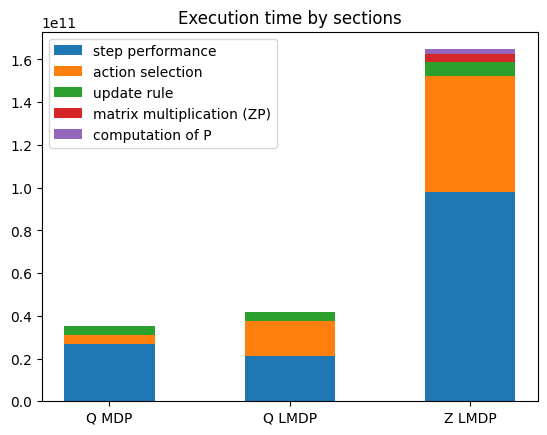

In [66]:
methods = ('Q MDP', 'Q LMDP', 'Z LMDP')
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for type, tim in new_total_timings.items():
    p = ax.bar(methods, tim, width, label=type, bottom=bottom)
    bottom += tim

ax.set_title("Execution time by sections")
ax.legend(loc="upper left")

plt.show()